In [1]:
import nibabel as nib
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import dicom
from PIL import Image
from skimage.transform import resize
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/Users/wloos/Documents/virtualenv/venv01/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
DATASET_STRUCTURED_DIR = "/Users/wloos/Desktop/BrainHack/out/"

def find_nii(DIR):
  files_CT = glob.glob(os.path.join(DIR,'*','*','*','*','*.nii'))
  print(len(files_CT))
  files_MR = glob.glob(os.path.join(DIR,'*','*','*','*','*','*.nii'))
  print(len(files_MR))

  return files_CT,files_MR

files_CT,files_MR = find_nii(DATASET_STRUCTURED_DIR)  

164
563


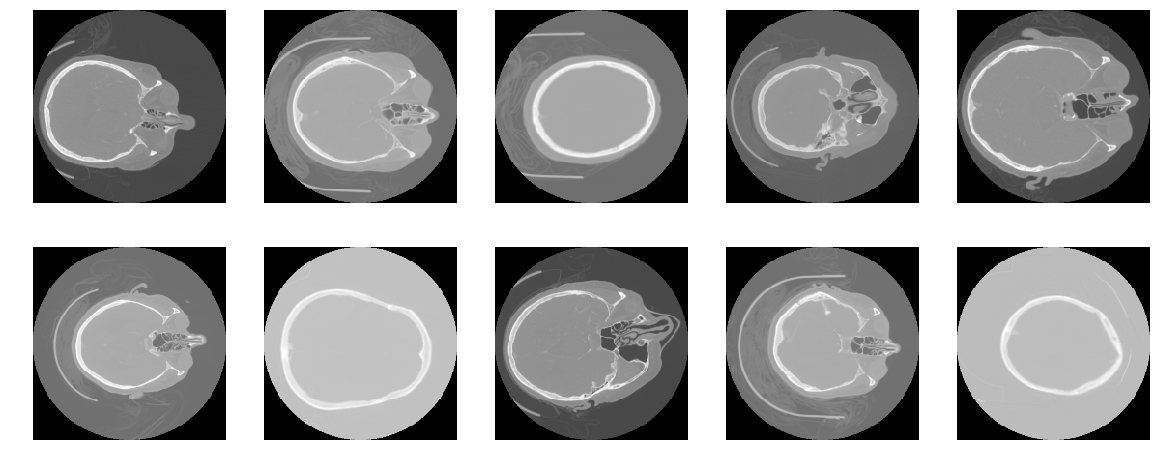

In [81]:
images = 10
plt.figure(figsize=(20,8))
for i in range(images):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    img = nib.load(files_CT[i])
    dt = img.get_data()
    slice_ = int(img.shape[2]*0.7)
    crop_data = dt[:,  :, slice_]
    crop_data_resized = resize(crop_data, (200, 200))
    crop_data_resized = crop_data_resized.reshape(200,200)
    plt.imshow(crop_data_resized, cmap='gray')

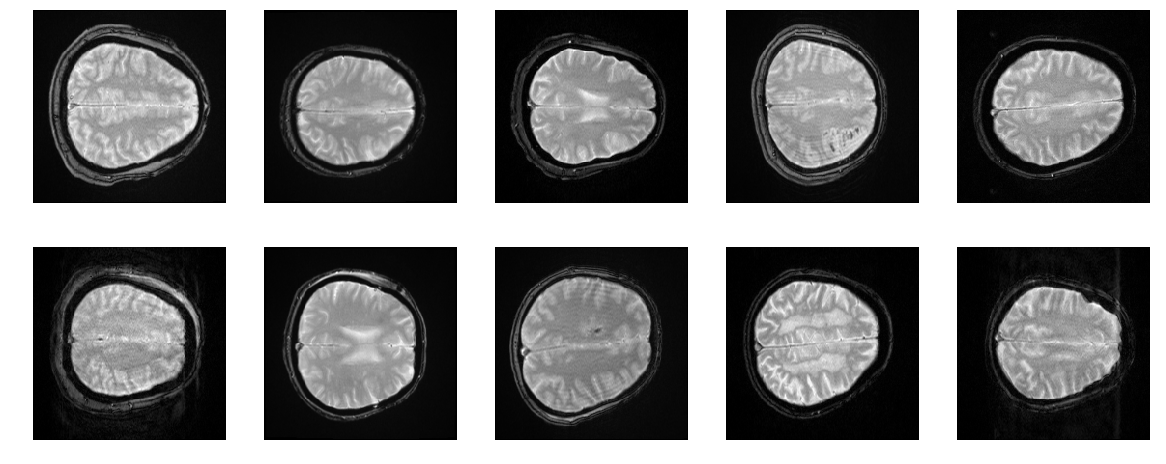

In [80]:
images = 10
plt.figure(figsize=(20,8))
for i in range(images):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    img = nib.load(files_MR[i])
    dt = img.get_data()
    mid = (img.shape[0]/2)
    slice_ = int(img.shape[2]*0.7)
    if len(img.shape) < 4:
        crop_data = dt[:,  :, slice_]
    else:
        crop_data = dt[:,  :, slice_, 0]

    crop_data_resized = resize(crop_data, (200, 200))
    crop_data_resized = crop_data_resized.reshape(200,200)
    plt.imshow(crop_data_resized, cmap='gray')

In [97]:
def create_labelled_data(files):
  nn = len(files)
  vol = np.empty([727, 40000])
  labels = np.empty([727,1])
  index = 0

  for ii in np.arange(nn):
    data = files[ii]
    print 'Number of exams:',(len(data))
    for i2 in np.arange(len(data)):
      y = np.zeros((18))
      name = data[i2]

      img = nib.load(name)
      dt = img.get_data()
      slice_ = int(img.shape[2]*0.7)
      if len(img.shape) < 4:
        crop_data = dt[:, :, slice_]
        crop_data_resized = resize(crop_data, (200, 200))
        crop_data_resized = crop_data_resized.ravel()
        vol[index,:] = crop_data_resized
        labels[index] = ii
        index = index+1
      else:
        crop_data = dt[:, :, slice_, 0]
        crop_data_resized = resize(crop_data, (200, 200))
        crop_data_resized = crop_data_resized.ravel()
        vol[index,:] = crop_data_resized
        labels[index] = ii
        index = index+1

  return vol, labels 

In [98]:
vol, labels = create_labelled_data([files_CT,files_MR])

Number of exams: 164
Number of exams: 563


In [99]:
print len(vol),len(labels)
label = labels.reshape(727)

727 727


In [100]:
tsne_result = TSNE(n_components=2).fit_transform(vol)

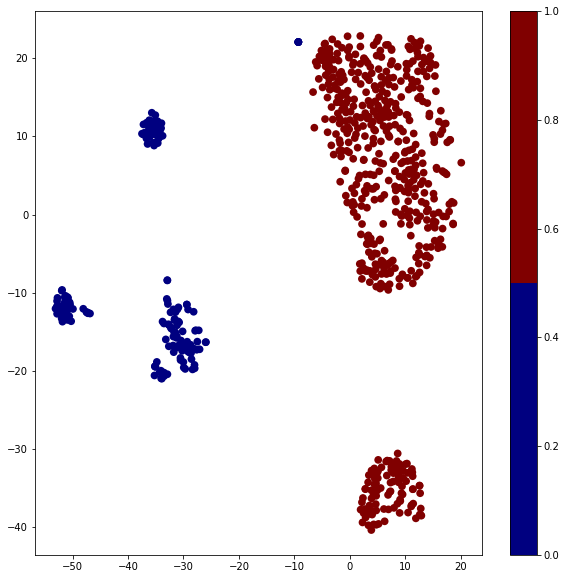

In [101]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=label[:], edgecolor='none', alpha=1.0,
           cmap=plt.get_cmap('jet', 2), s=60)
plt.colorbar()
plt.show()

In [87]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(tsne_result)
y_kmeans = kmeans.predict(tsne_result)

In [88]:
score = metrics.accuracy_score(label,1-y_kmeans)
print('Accuracy:{0:f}'.format(score))

Accuracy:0.993122


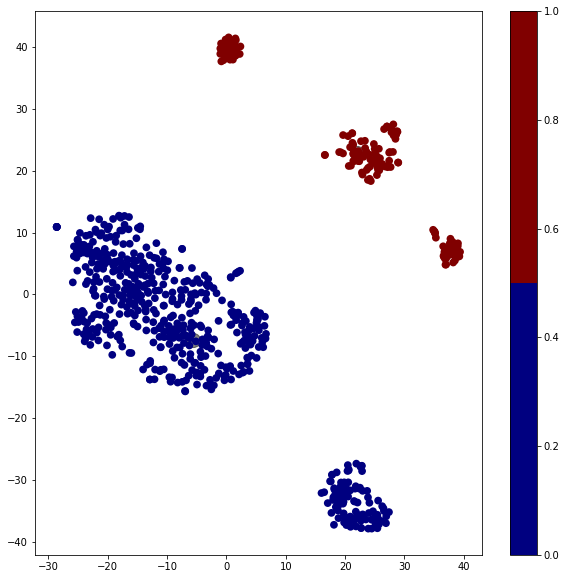

In [89]:
plt.figure(figsize=(10, 10))
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c= y_kmeans, edgecolor='none', alpha=1.0,
           cmap=plt.get_cmap('jet', 2), s=60)
plt.colorbar()
plt.show()